# Contributing Factors Analysis

## README

### Overview
This notebook analyses various spatial datasets that may contribute to or correlate with nitrogen dioxide (NO₂) pollution levels in Ethiopia (Addis Ababa) and Iraq (Baghdad). It focuses on road infrastructure, points of interest (POIs), active fire product and population distribution as potential explanatory variables.

### Objective
The goal is to examine the spatial distribution of key human and infrastructural factors that may influence or correlate with nitrogen dioxide (NO₂) pollution levels in urban areas.

### Workflow

1. **Data Acquisition**
   - Downloads datasets from multiple sources:
     - OpenStreetMap (OSM) for roads, industrial facilities, and POIs for [Ethiopia](https://download.geofabrik.de/africa/ethiopia-latest-free.shp.zip) and [Iraq](https://download.geofabrik.de/asia/iraq-latest-free.shp.zip)
     - [WorldPop](https://data.humdata.org/search?q=Spatial+Distribution+of+Population+&ext_search_source=main-nav) for population density
     - [MODIS/VIIRS datasets](https://www.earthdata.nasa.gov/data/instruments/viirs) for fire events
   - Imports country and city boundary shapefiles for Ethiopia and Iraq.

2. **Data Processing**
   - Clips all spatial layers to city-level boundaries. 
   - Aggregates various indicators into uniform mesh grids for spatial comparison.

3. **Visualisation**
   - Generates static maps of population density, road infrastructure, and fire event distribution.
   - Visualises spatial variation in contributing factors to support exploratory analysis.

### Outputs

- **Processed Shapefiles**: City-level road, POI, fire, and infrastructure layers.
- **Mesh-Based Aggregated Tables**: Feature counts and densities per grid cell.
- **Static Visualisations**: Choropleth maps for all contributing factors to aid spatial interpretation.
- **Harmonised Datasets**: All outputs aligned spatially and ready for merging with NO₂ concentration data.

## 0 Prepare Packages

In [ ]:
# ! pip install pandas osmnx geopandas osm2geojson requests urllib3 shapely matplotlib rasterstats numpy rasterio pyarrow

## 1 Road network and POI data

In this chapter, three parts are included:

1. **Data Download.** Including code to download data from OpenStreetMap(OSM), [OSM Ethiopia](https://download.geofabrik.de/africa/ethiopia-latest-free.shp.zip) and [OSM Iraq](https://download.geofabrik.de/asia/iraq-latest-free.shp.zip).
2. **Data Processing Pipeline.** Mainly includes **clipping** data that exceeds the interested boundary and aggregating data based on the synthesised mesh.
3. **Data Visualization.** Generate the visualization of the aggregated data.

### 1.1 OSM Data Download

#### Install & import libraries, define folder structure

In [ ]:
import pandas as pd
import osmnx as ox
import geopandas as gpd
from pathlib import Path
import osm2geojson
import requests
import urllib3
from shapely.geometry import Point

In [ ]:
# Define base data directory and subfolders
base_dir = Path(r"C:\Users\Luis.ParraMorales\OneDrive - Imperial College London\Group Design Project\Data")
folders = {
    "boundaries": base_dir / "boundaries",
    "roads":      base_dir / "roads",
    "industry":   base_dir / "industry",
    "energy":     base_dir / "energy",
}
for path in folders.values():
    path.mkdir(parents=True, exist_ok=True)

# OSMnx settings
ox.settings.use_cache        = True
ox.settings.log_console      = True
ox.settings.requests_kwargs  = {"verify": False}

#### 1) Country/city boundaries (Ethiopia and Baghdad)

In [ ]:
# Define queries
areas = {
    "ethiopia": "Ethiopia, Africa",
    "baghdad":  "Baghdad, Iraq",
}

# Dictionary to hold geometry polygons
boundaries = {}

for name, query in areas.items():
    print(f"Fetching boundary for {name}...")
    gdf = ox.geocode_to_gdf(query)
    poly = gdf.loc[0, "geometry"]
    boundaries[name] = poly
    # save as shapefile
    out_fp = folders["boundaries"] / f"{name}_boundary.shp"
    gdf.to_file(out_fp)
    print(f"Saved boundary to {out_fp}")


#### 2) Road networks

In [ ]:
# Read Ethiopia subregions
subregs = gpd.read_file(folders["boundaries"] / "ethiopia_subregions.gpkg")

# Define the road filter
road_types = ["motorway","trunk","primary","secondary","tertiary"]
filter_str = f'["highway"~"^({"|".join(road_types)})$"]'

ethi_roads_parts = []
for _, row in subregs.iterrows():
    region_name = row["region_name"]
    poly = row["geometry"]
    print(f"Fetching roads for Ethiopia – {region_name}…")
    try:
        G = ox.graph_from_polygon(poly, custom_filter=filter_str)
        roads = ox.graph_to_gdfs(G, nodes=False, edges=True, fill_edge_geometry=True)
        roads["region_name"] = region_name
        ethi_roads_parts.append(roads)
    except Exception as e:
        print(f"   skipped {region_name}: {e}")

# Concatenate and save Ethiopia roads
ethi_roads = pd.concat(ethi_roads_parts, ignore_index=True)
out_fp_eth = folders["roads"] / "ethiopia_roads.shp"
ethi_roads.to_file(out_fp_eth)
print(f"Saved Ethiopia roads to {out_fp_eth}")

# Fetch Baghdad’s roads
print("📥 Fetching roads for Baghdad…")
G_bag = ox.graph_from_place("Baghdad, Iraq", custom_filter=filter_str)
bag_roads = ox.graph_to_gdfs(G_bag, nodes=False, edges=True, fill_edge_geometry=True)
out_fp_bag = folders["roads"] / "baghdad_roads.shp"
bag_roads.to_file(out_fp_bag)
print(f"Saved Baghdad roads to {out_fp_bag}")


#### 3) Industrial features & power plants

In [ ]:
# 1) SSL off & HTTP endpoints
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
ox.settings.requests_kwargs    = {"verify": False}
ox.settings.nominatim_endpoint = "http://nominatim.openstreetmap.org/search"
ox.settings.overpass_endpoint  = "http://overpass-api.de/api/interpreter"

# 2) Ensure poi folder exists
folders["poi"] = folders.get("poi", folders["industry"].parent / "poi")
folders["poi"].mkdir(parents=True, exist_ok=True)

# 3) Tags for POIs
poi_tags = {
    "amenity": [
        "bus_station","bus_stop","parking","fuel","marketplace",
        "school","college","university","hospital","clinic",
        "bank","restaurant","cafe","fast_food","bar","police","fire_station"
    ],
    "shop": True,
    "highway": ["bus_stop","bus_station"],
    "railway": ["station","halt","tram_stop"],
    "aeroway": ["aerodrome","helipad","terminal"],
    "landuse": ["industrial"],
    "man_made": ["works","chimney","storage_tank"],
    "power": ["plant","substation","generator","tower","transformer"],
    "office": True,
    "craft": True,
    "place": ["city","town","village","suburb","neighbourhood","hamlet"],
}

# 4) Ethiopia – loop per subregion
subregs    = gpd.read_file(folders["boundaries"] / "ethiopia_subregions.gpkg")
ethi_parts = []

for _, row in subregs.iterrows():
    region = row["region_name"]
    poly   = row.geometry
    print(f"📥 Fetching POIs for Ethiopia – {region} …")
    try:
        gdf = ox.features_from_polygon(poly, tags=poi_tags)
        if gdf.empty:
            continue
        # convert all non-Points to centroids
        gdf["geometry"] = gdf.geometry.apply(
            lambda g: g if isinstance(g, Point) else g.centroid
        )
        gdf["region_name"] = region
        ethi_parts.append(gdf)
    except Exception as e:
        print(f"   Skipped {region}: {e}")

if ethi_parts:
    ethi_pois = pd.concat(ethi_parts, ignore_index=True).set_crs("EPSG:4326")
    # drop duplicate columns
    ethi_pois = ethi_pois.loc[:, ~ethi_pois.columns.duplicated()]
    # drop any fixme column
    for bad in ["fixme", "FIXME"]:
        if bad in ethi_pois.columns:
            ethi_pois = ethi_pois.drop(columns=bad)
    out_eth = folders["poi"] / "ethiopia_pois.gpkg"
    ethi_pois.to_file(out_eth, driver="GPKG")
    print(f"Saved Ethiopia POIs to {out_eth}")
else:
    print("No Ethiopia POIs fetched.")

# 5) Baghdad – single call
print("Fetching POIs for Baghdad …")
bag_poly = boundaries.get("baghdad") or ox.geocode_to_gdf("Baghdad, Iraq").geometry.iloc[0]

try:
    bag_pois = ox.features_from_polygon(bag_poly, tags=poi_tags)
    bag_pois["geometry"] = bag_pois.geometry.apply(
        lambda g: g if isinstance(g, Point) else g.centroid
    )
    bag_pois["region_name"] = "Baghdad"
    # drop duplicate columns
    bag_pois = bag_pois.loc[:, ~bag_pois.columns.duplicated()]
    # drop any fixme column
    if "fixme" in bag_pois.columns:
        bag_pois = bag_pois.drop(columns="fixme")
    out_bag = folders["poi"] / "baghdad_pois.gpkg"
    bag_pois.to_file(out_bag, driver="GPKG")
    print(f"Saved Baghdad POIs to {out_bag}")
except Exception as e:
    print(f"Failed to fetch Baghdad POIs: {e}")

#### 4) Energy-grid components

In [ ]:
# 1) Disable SSL verification & warnings, force HTTP endpoints
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
ox.settings.requests_kwargs    = {"verify": False}
ox.settings.nominatim_endpoint = "http://nominatim.openstreetmap.org/search"
ox.settings.overpass_endpoint  = "http://overpass-api.de/api/interpreter"

# 2) Ensure energy folder exists
folders["energy"].mkdir(parents=True, exist_ok=True)

# 3) Define tags for grid components
grid_tags = {
    "power": ["line", "substation", "transformer", "tower"]
}

# 4) Ethiopia – loop per admin_level=4 subregion
subregs   = gpd.read_file(folders["boundaries"] / "ethiopia_subregions.gpkg")
eth_parts = []

for _, row in subregs.iterrows():
    region   = row["region_name"]
    poly     = row.geometry
    print(f"Fetching energy‐grid for Ethiopia – {region} …")
    try:
        gdf = ox.features_from_polygon(poly, tags=grid_tags)
        if gdf.empty:
            continue
        # tag the region
        gdf["region_name"] = region
        # drop any duplicate columns
        gdf = gdf.loc[:, ~gdf.columns.duplicated()]
        # drop problematic 'fixme' field if present
        for bad in ["fixme", "FIXME"]:
            if bad in gdf.columns:
                gdf = gdf.drop(columns=bad)
        eth_parts.append(gdf)
    except Exception as e:
        print(f"   Skipped {region}: {e}")

# 5) Save Ethiopia grid
if eth_parts:
    eth_grid = pd.concat(eth_parts, ignore_index=True).set_crs("EPSG:4326")
    out_eth = folders["energy"] / "ethiopia_energy_grid.gpkg"
    eth_grid.to_file(out_eth, driver="GPKG")
    print(f"Saved Ethiopia energy grid to {out_eth}")
else:
    print("No Ethiopia energy‐grid features fetched.")

# 6) Baghdad – single call
print("Fetching energy‐grid for Baghdad …")
bag_poly = boundaries.get("baghdad") or ox.geocode_to_gdf("Baghdad, Iraq").geometry.iloc[0]

try:
    bag_gdf = ox.features_from_polygon(bag_poly, tags=grid_tags)
    bag_gdf["region_name"] = "Baghdad"
    bag_gdf = bag_gdf.loc[:, ~bag_gdf.columns.duplicated()]
    if "fixme" in bag_gdf.columns:
        bag_gdf = bag_gdf.drop(columns="fixme")
    out_bag = folders["energy"] / "baghdad_energy_grid.gpkg"
    bag_gdf.to_file(out_bag, driver="GPKG")
    print(f"Saved Baghdad energy grid to {out_bag}")
except Exception as e:
    print(f"Failed to fetch Baghdad energy‐grid: {e}")


### 1.2 OSM Data Process Pipeline

#### City: Addis Ababa

#### 0) Import packages and set parameters

Import all packages and set environment.

In [ ]:
# ## 0. Environment & Libraries

# %%
import os
import geopandas as gpd
import pandas as pd
import logging
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

#### 0) Paths and parameters.

In [ ]:
# ## 1. Paths & Parameters

# %%
base_dir = r"C:\Users\Luis.ParraMorales\OneDrive - Imperial College London\Group Design Project"
paths = {
    "pois":     os.path.join(base_dir, r"ethiopia-latest-free.shp\gis_osm_pois_free_1.shp"),
    "roads":    os.path.join(base_dir, r"ethiopia-latest-free.shp\gis_osm_roads_free_1.shp"),
    "boundary": os.path.join(base_dir, r"Boundary_Mesh\addis_ababa_boundary.geojson"),  # adjust if needed
    "mesh":     os.path.join(base_dir, r"Boundary_Mesh\addis_ababa_mesh_5km.gpq"),
}
out_dir = os.path.join(base_dir, "processed", "addis_ababa")
os.makedirs(out_dir, exist_ok=True)
target_crs = "EPSG:32637"

#### 2) Read and reproject the boundary and mesh.

In [ ]:
# ## 2. Read & Reproject Boundary and Mesh

boundary = gpd.read_file(paths["boundary"])
logging.info(f"Boundary CRS before: {boundary.crs}")
boundary = boundary.to_crs(target_crs)

mesh = gpd.read_parquet(paths["mesh"])
logging.info(f"Mesh CRS before: {mesh.crs}")
mesh = mesh.to_crs(target_crs)


#### 3) Clip National layers to city level

In [ ]:
# ## 3. Clip National Layers to City Boundary

# %%
pois_clipped = gpd.read_file(paths["pois"], mask=boundary).to_crs(target_crs)
logging.info(f"Clipped POIs: {len(pois_clipped)}")

roads_clipped = gpd.read_file(paths["roads"], mask=boundary).to_crs(target_crs)
logging.info(f"Clipped Roads: {len(roads_clipped)}")

def write_clip(gdf, name):
    gdf.to_file(os.path.join(out_dir, f"{name}.gpkg"), driver="GPKG")
    gdf.to_file(os.path.join(out_dir, f"{name}.geojson"), driver="GeoJSON")
    gdf.to_file(os.path.join(out_dir, f"{name}.shp"),   driver="ESRI Shapefile")
    logging.info(f"Wrote clipped {name}")

write_clip(pois_clipped, "addis_ababa_pois_clip")
write_clip(roads_clipped, "addis_ababa_roads_clip")


#### 4) Attributes generator for new Mesh attributes from data sources

In [ ]:
# ## 4. Define Relevant Classes
relevant_poi = [
    "bank","restaurant","cafe","hotel","school","bakery","pharmacy","supermarket",
    "bar","guesthouse","atm","clinic","attraction","fast_food","clothes",
    "furniture_shop","college","hospital","hairdresser","greengrocer","laundry",
    "doityourself","dentist","beverages","car_dealership","hostel","post_office",
    "computer_shop","mobile_phone_shop","department_store","beauty_shop","butcher",
    "cinema","gift_shop","optician","nightclub","bookshop","stationery","doctors",
    "pub","car_rental","car_wash","kindergarten","market_place","shoe_shop",
    "motel","sports_shop","nursing_home","florist","jeweller","mall","bicycle_shop",
    "toy_shop","veterinary","chemist","sports_centre","outdoor_shop","video_shop",
    "theatre","food_court","university"
]

relevant_road = [
    "residential","service","primary","secondary","primary_link",
    "secondary_link","tertiary_link","motorway","motorway_link"
]


#### 5) Enrich Mesh with POI attributes

In [ ]:
# ## 5. Enrich Mesh with Relevant POI Counts

# %%
# 5.1 Spatial join & count all
sjoin_poi = gpd.sjoin(
    pois_clipped,
    mesh[["GRID_ID","geometry"]],
    predicate="within", how="inner"
)[["GRID_ID","fclass"]]

poic = sjoin_poi.groupby(["GRID_ID","fclass"]).size().reset_index(name="count")
poi_all = poic.groupby("GRID_ID")["count"].sum().rename("poi_all_count")

# 5.2 Filter relevant & pivot
poic_rel = poic[poic["fclass"].isin(relevant_poi)]
poi_wide = poic_rel.pivot(index="GRID_ID", columns="fclass", values="count").fillna(0)

# 5.3 Build enriched mesh subset
mesh_sel = mesh.set_index("GRID_ID").copy()
for cls in relevant_poi:
    mesh_sel[f"{cls}_c"] = poi_wide.get(cls, pd.Series(0)).reindex(mesh_sel.index, fill_value=0)

# 5.4 Summary counts
mesh_sel["poi_rel_count"]   = mesh_sel[[f"{c}_c" for c in relevant_poi]].sum(axis=1)
mesh_sel["poi_all_count"]   = poi_all.reindex(mesh_sel.index, fill_value=0)
mesh_sel["poi_other_count"] = mesh_sel["poi_all_count"] - mesh_sel["poi_rel_count"]

logging.info("POI enrichment complete.")


#### 6) Enrich Mesh with road attributes

In [ ]:
# ## 6. Enrich Mesh with Relevant Road Lengths

# %%
# 6.1 Compute segment length (km)
roads_clipped["seg_km"] = roads_clipped.geometry.length / 1000.0

# 6.2 Spatial join & sum all
sjoin_rd = gpd.sjoin(
    roads_clipped[["fclass","seg_km","geometry"]],
    mesh_sel[["geometry"]],
    predicate="intersects", how="inner"
)[["GRID_ID","fclass","seg_km"]]

roadc = sjoin_rd.groupby(["GRID_ID","fclass"])["seg_km"].sum().reset_index()
road_all = roadc.groupby("GRID_ID")["seg_km"].sum().rename("road_all_km")

# 6.3 Filter relevant & pivot
road_rel = roadc[roadc["fclass"].isin(relevant_road)]
road_wide = road_rel.pivot(index="GRID_ID", columns="fclass", values="seg_km").fillna(0)

# 6.4 Add to mesh + summaries
for cls in relevant_road:
    mesh_sel[f"{cls}_km"] = road_wide.get(cls, pd.Series(0)).reindex(mesh_sel.index, fill_value=0)

mesh_sel["road_rel_km"]   = mesh_sel[[f"{c}_km" for c in relevant_road]].sum(axis=1)
mesh_sel["road_all_km"]   = road_all.reindex(mesh_sel.index, fill_value=0)
mesh_sel["road_other_km"] = mesh_sel["road_all_km"] - mesh_sel["road_rel_km"]

logging.info("Road enrichment complete.")

mesh_sel = mesh_sel.reset_index()

#### 7) Write GIS files for Enriched Mesh

In [ ]:
# ## 7. Write Enriched Mesh

# %%
def write_enriched(gdf, name):
    gdf.to_file(os.path.join(out_dir, f"{name}.gpkg"), driver="GPKG")
    gdf.to_file(os.path.join(out_dir, f"{name}.geojson"), driver="GeoJSON")
    gdf.to_file(os.path.join(out_dir, f"{name}.shp"),   driver="ESRI Shapefile")
    logging.info(f"Wrote enriched mesh: {name}")

write_enriched(mesh_sel, "addis_ababa_mesh_selected_enriched")


### Visualization for Addis Ababa

#### 8) Logging some plots

In [ ]:
# ## 8. QC / Logging & Summary Plots

# Summary statistics
print(f"Mesh cells: {len(mesh_sel)}")
print(f"Relevant POI fields: {len(relevant_poi)}")
print(f"Relevant Road fields: {len(relevant_road)}")
print(f"New columns added: {len(mesh_sel.columns) - len(mesh.columns)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

mesh_sel.plot(
    column="poi_rel_count", ax=ax1, legend=True,
    legend_kwds={"label":"Relevant POI Count","shrink":0.6}
)
ax1.set_title("Relevant POI Count per 5km Cell")
ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")

mesh_sel.plot(
    column="residential_km", ax=ax2, legend=True,
    legend_kwds={"label":"Residential Road Length (km)","shrink":0.6}
)
ax2.set_title("Residential Road Length per 5km Cell")
ax2.set_xlabel("Easting (m)")

plt.tight_layout()
plt.show()


Explore fclasses of POI and Road in order to save the appropiate

In [ ]:
# import os
# import geopandas as gpd

# # Adjust these paths if your outputs live elsewhere
# base_dir = r"C:\Users\Luis.ParraMorales\OneDrive - Imperial College London\Group Design Project"
# processed_dir = os.path.join(base_dir, "processed", "addis_ababa")

# # Load clipped datasets
# pois = gpd.read_file(os.path.join(processed_dir, "addis_ababa_pois_clip.gpkg"))
# roads = gpd.read_file(os.path.join(processed_dir, "addis_ababa_roads_clip.gpkg"))

# # POI classes and counts
# poi_counts = pois["fclass"].value_counts()
# print("=== POI classes ===")
# print(poi_counts.to_string())

In [ ]:
# # Road classes and counts
# road_counts = roads["fclass"].value_counts()
# print("\n=== Road classes ===")
# print(road_counts.to_string())

In [ ]:
# poi_counts.to_csv("pois_values.csv",index=True)
# road_counts.to_csv("road_values.csv",index=True)

#### City: Baghdad

#### 9) Paths & Parameters for Baghdad

In [ ]:
# ## Baghdad POI & Road-to-Mesh Pre-Processing (Relevant-Only, UTM 38 N)

# ### 9.1 Paths & Parameters for Baghdad

# Reuse relevant_poi, relevant_road from above
# Set up logging if not already
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

base_dir = r"C:\Users\Luis.ParraMorales\OneDrive - Imperial College London\Group Design Project"
paths_bg = {
    "boundary": os.path.join(base_dir, r"Boundary_Mesh\baghdad_boundary.geojson"),
    "mesh":     os.path.join(base_dir, r"Boundary_Mesh\baghdad_mesh_5km.gpq"),
    "pois":     os.path.join(base_dir, r"iraq-latest-free.shp\gis_osm_pois_free_1.shp"),
    "roads":    os.path.join(base_dir, r"iraq-latest-free.shp\gis_osm_roads_free_1.shp"),
}
out_dir_bg = os.path.join(base_dir, "processed", "baghdad")
os.makedirs(out_dir_bg, exist_ok=True)

target_crs_bg = "EPSG:32638"  # UTM Zone 38 N for Baghdad

# Reuse helper functions from above:
#   write_clip(gdf, name)  
#   write_enriched(gdf, name)
# and the lists relevant_poi, relevant_road

In [ ]:
# ### 9.2 Read & Reproject Boundary and Mesh

boundary_bg = gpd.read_file(paths_bg["boundary"])
logging.info(f"Baghdad boundary CRS before: {boundary_bg.crs}")
boundary_bg = boundary_bg.to_crs(target_crs_bg)

mesh_bg = gpd.read_parquet(paths_bg["mesh"])
logging.info(f"Baghdad mesh CRS before: {mesh_bg.crs}")
mesh_bg = mesh_bg.to_crs(target_crs_bg)

In [ ]:
# ### 9.3 Clip National POI & Road Layers

pois_bg = (
    gpd.read_file(paths_bg["pois"], mask=boundary_bg)
       .to_crs(target_crs_bg)
)
logging.info(f"Clipped Baghdad POIs: {len(pois_bg)}")

roads_bg = (
    gpd.read_file(paths_bg["roads"], mask=boundary_bg)
       .to_crs(target_crs_bg)
)
logging.info(f"Clipped Baghdad Roads: {len(roads_bg)}")

# Write clipped Baghdad layers
write_clip(pois_bg,  "baghdad_pois_clip")
write_clip(roads_bg, "baghdad_roads_clip")

In [ ]:
# ### 9.4 Enrich Baghdad Mesh with Relevant POI Counts

sjoin_poi_bg = gpd.sjoin(
    pois_bg,
    mesh_bg[["GRID_ID","geometry"]],
    predicate="within", how="inner"
)[["GRID_ID","fclass"]]

poic_bg     = sjoin_poi_bg.groupby(["GRID_ID","fclass"]).size().reset_index(name="count")
poi_all_bg  = poic_bg.groupby("GRID_ID")["count"].sum().rename("poi_all_count")
poic_rel_bg = poic_bg[poic_bg["fclass"].isin(relevant_poi)]
poi_wide_bg = poic_rel_bg.pivot(index="GRID_ID", columns="fclass", values="count").fillna(0)

mesh_bg_sel = mesh_bg.set_index("GRID_ID").copy()
for cls in relevant_poi:
    mesh_bg_sel[f"{cls}_c"] = poi_wide_bg.get(cls, pd.Series(0))\
                                     .reindex(mesh_bg_sel.index, fill_value=0)

mesh_bg_sel["poi_rel_count"]   = mesh_bg_sel[[f"{c}_c" for c in relevant_poi]].sum(axis=1)
mesh_bg_sel["poi_all_count"]   = poi_all_bg.reindex(mesh_bg_sel.index, fill_value=0)
mesh_bg_sel["poi_other_count"] = mesh_bg_sel["poi_all_count"] - mesh_bg_sel["poi_rel_count"]

logging.info("Baghdad POI enrichment complete.")


In [ ]:
# ### 9.5 Enrich Baghdad Mesh with Relevant Road Lengths

roads_bg["seg_km"] = roads_bg.geometry.length / 1000.0

sjoin_rd_bg = gpd.sjoin(
    roads_bg[["fclass","seg_km","geometry"]],
    mesh_bg_sel[["geometry"]],
    predicate="intersects", how="inner"
)[["GRID_ID","fclass","seg_km"]]

roadc_bg    = sjoin_rd_bg.groupby(["GRID_ID","fclass"])["seg_km"]\
                          .sum().reset_index()
road_all_bg = roadc_bg.groupby("GRID_ID")["seg_km"].sum().rename("road_all_km")
road_rel_bg = roadc_bg[roadc_bg["fclass"].isin(relevant_road)]
road_wide_bg= road_rel_bg.pivot(index="GRID_ID", columns="fclass", values="seg_km").fillna(0)

for cls in relevant_road:
    mesh_bg_sel[f"{cls}_km"] = road_wide_bg.get(cls, pd.Series(0))\
                                         .reindex(mesh_bg_sel.index, fill_value=0)

mesh_bg_sel["road_rel_km"]   = mesh_bg_sel[[f"{c}_km" for c in relevant_road]].sum(axis=1)
mesh_bg_sel["road_all_km"]   = road_all_bg.reindex(mesh_bg_sel.index, fill_value=0)
mesh_bg_sel["road_other_km"] = mesh_bg_sel["road_all_km"] - mesh_bg_sel["road_rel_km"]

logging.info("Baghdad road enrichment complete.")

mesh_bg_sel = mesh_bg_sel.reset_index()

In [ ]:
# ### 9.6 Write Enriched Baghdad Mesh
write_enriched(mesh_bg_sel, "baghdad_mesh_selected_enriched")


### Visualization for Baghdad

In [ ]:
# ### 9.7 QC & Visualization for Baghdad

print(f"Baghdad mesh cells: {len(mesh_bg_sel)}")
print(f"Relevant POI fields: {len(relevant_poi)}")
print(f"Relevant Road fields: {len(relevant_road)}")
print(f"New columns added: {len(mesh_bg_sel.columns) - len(mesh_bg.columns)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

mesh_bg_sel.plot(
    column="poi_rel_count", ax=ax1, legend=True,
    legend_kwds={"label":"Relevant POI Count","shrink":0.6}
)
ax1.set_title("Baghdad: Relevant POI Count per 5km Cell")
ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")

mesh_bg_sel.plot(
    column="residential_km", ax=ax2, legend=True,
    legend_kwds={"label":"Residential Road Length (km)","shrink":0.6}
)
ax2.set_title("Baghdad: Residential Road Length per 5km Cell")
ax2.set_xlabel("Easting (m)")

plt.tight_layout()
plt.show()


## 2 Population Data

### 2.1 Custom Fuctions

In [2]:
import geopandas as gpd
from rasterstats import zonal_stats
import numpy as np
import matplotlib.pyplot as plt
import os
import rasterio
from pathlib import Path

# Global Paths
demo_dir = Path(r'D:/Projects/MSc_Group_Project/no2_economicactivity_gdp/demo-data')
data_dir = Path(r'C:/Users/26454/OneDrive - Imperial College London/Desktop/group design project/Data/World population')


In [3]:
# Function: read tiff files
def read_tiff(filename):
    with rasterio.open(filename) as src:
        band = src.read(1)          # first band
        profile = src.profile       # meta data
        nodata_value = src.nodata   # get nodata (missing)

    return src, band, profile, nodata_value

# Function: Aggregate data within each hexagon
def aggregate_to_mesh(hex_mesh, tiff_path):
    with rasterio.open(tiff_path) as src:
        nodata_val = src.nodata or -99999.0
    stats = zonal_stats(hex_mesh, tiff_path, stats=["sum"], nodata=nodata_val)
    hex_mesh["pop_sum_m"] = [max(0, s["sum"] or 0) for s in stats]
    return hex_mesh

# Load the mesh
os.chdir(demo_dir)
hex_addis_gdf = gpd.read_parquet("addis_ababa_mesh_5km.gpq")
hex_baghdad_gdf = gpd.read_parquet("baghdad_mesh_5km.gpq")

### 2.2 Aggregate Ethiopia - Addis Ababa

In [ ]:
os.chdir(data_dir)

# Aggregate Ethiopia - Addis Ababa
eth_pop_filled_path = os.path.join('Ethiopia - Spatial Distribution of Population (2015-2030)')
eth_filled_tiffs = [f for f in os.listdir(eth_pop_filled_path) if f.lower().endswith('.tif')]
r_eth_filled_paths = [os.path.join(eth_pop_filled_path, f) for f in eth_filled_tiffs] # relative path
# print(r_eth_filled_paths)

# Create a folder to save filled data
output_dir = 'addis_ababa_pop_mesh'
city = 'addis_ababa'

# Create folder saving filled data
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for index, tiff_path in enumerate(r_eth_filled_paths):

    year = eth_filled_tiffs[index].split('_')[2].split('.')[0]
    # Trace progress
    print(f"currently working on: {index+1}, {year}" ) 

    new_hex_mesh = aggregate_to_mesh(hex_addis_gdf, tiff_path)

    # Save as Parquet
    output_file = os.path.join(output_dir, f'{city}_hex_{year}_pop.parquet')
    new_hex_mesh.to_parquet(output_file)

#### Visualization

Demonstrate Addis Ababa population mesh in 2022.

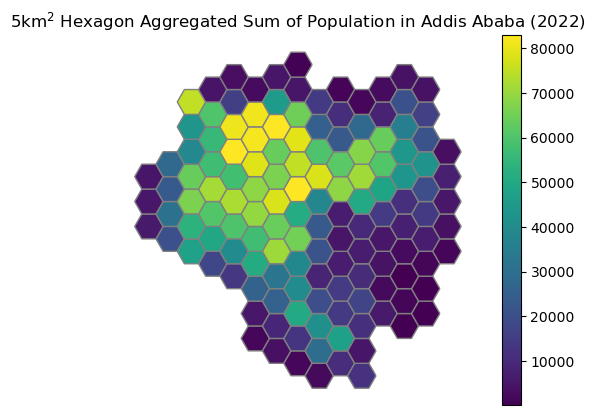

In [11]:
os.chdir(demo_dir)
hex_gdf = gpd.read_parquet('addis_ababa_hex_2022_pop.parquet')

# visual
hex_gdf.plot(column="pop_sum_m", edgecolor="grey", legend=True)
plt.title("5km$^2$ Hexagon Aggregated Sum of Population in Addis Ababa (2022)")
plt.axis("off")
plt.show()

### 2.3 Aggregate Iraq - Baghdad

In [ ]:
os.chdir(data_dir)
# Aggregate Iraq - Baghdad
iraq_pop_filled_path = os.path.join('Iraq - Spatial Distribution of Population (2015-2030)')
iraq_filled_tiffs = [f for f in os.listdir(iraq_pop_filled_path) if f.lower().endswith('.tif')]
r_iraq_filled_paths = [os.path.join(iraq_pop_filled_path, f) for f in iraq_filled_tiffs] # relative path
# print(r_iraq_filled_paths)

# Create a folder to save filled data
output_dir = 'baghdad_pop_mesh'
city = 'baghdad'

# Create folder saving filled data
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for index, tiff_path in enumerate(r_iraq_filled_paths):

    year = iraq_filled_tiffs[index].split('_')[2].split('.')[0]
    # Trace progress
    print(f"currently working on: {index+1}, {year}" ) 

    new_hex_mesh = aggregate_to_mesh(hex_baghdad_gdf, tiff_path)

    # Save as Parquet
    output_file = os.path.join(output_dir, f'{city}_hex_{year}_pop.parquet')
    new_hex_mesh.to_parquet(output_file)

#### Visualization

Demonstrate Baghdad population mesh in 2022.

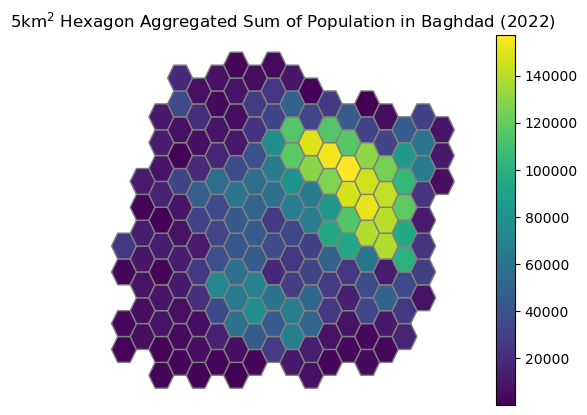

In [8]:
os.chdir(demo_dir)
hex_gdf = gpd.read_parquet('baghdad_hex_2022_pop.parquet')

# visual
hex_gdf.plot(column="pop_sum_m", cmap="viridis", edgecolor="grey", legend=True)
plt.title("5km$^2$ Hexagon Aggregated Sum of Population in Baghdad (2022)")
plt.axis("off")
plt.show()

## 3 Fire Data

### 3.1 Prepare Packages

In [ ]:
import numpy as np
import geopandas as gpd
from rasterstats import zonal_stats
import pyarrow
import pandas as pd
import matplotlib.pyplot as plt

### 3.2 Aggregate Fire Event Data

In [ ]:
# Step 1: load 5km mesh
mesh = gpd.read_file("/Users/JiaSyuan/Desktop/Group 1 Design Project/Code/baghdad_mesh_5km_JS.geojson")
mesh = mesh.to_crs("EPSG:4326") 

# Step 2: Specify the fire raster file
raster_path = "/Users/JiaSyuan/Downloads/FireMask_20220325.tif"

# Step 3: Perform zonal statistics aggregation
# Fire pixel values: 7 (high confidence), 8 (nominal), 9 (low)
# Only count pixels fully contained in each polygon
stats = zonal_stats(
    mesh, raster_path,
    stats="count",
    nodata=0,
    raster_out=False,
    categorical=True,
    all_touched=False  
)

# Step 4: Integrate zonal stats results into the mesh
mesh["fire_high_conf"] = [s.get(7, 0) for s in stats]  # Count of high confidence fire pixels (value 7)
mesh["fire_nom_conf"] = [s.get(8, 0) for s in stats]  # Count of nominal confidence fire pixels (value 8)
mesh["fire_low_conf"] = [s.get(9, 0) for s in stats]  # Count of low confidence fire pixels (value 9)
mesh["fire_total"] = mesh[["fire_high_conf", "fire_nom_conf", "fire_low_conf"]].sum(axis=1) # Total fire pixel count (sum of all confidence levels)

# Step 5: Export to .gpq or .csv format
output_path = "/Users/JiaSyuan/Desktop/Group 1 Design Project/Code/fire_agg_baghdad_2022177.gpq"
mesh.to_parquet(output_path)

print("Output：", output_path)


Output： /Users/JiaSyuan/Desktop/Group 1 Design Project/Code/fire_agg_baghdad_2022177.gpq


### 3.3 Visualization

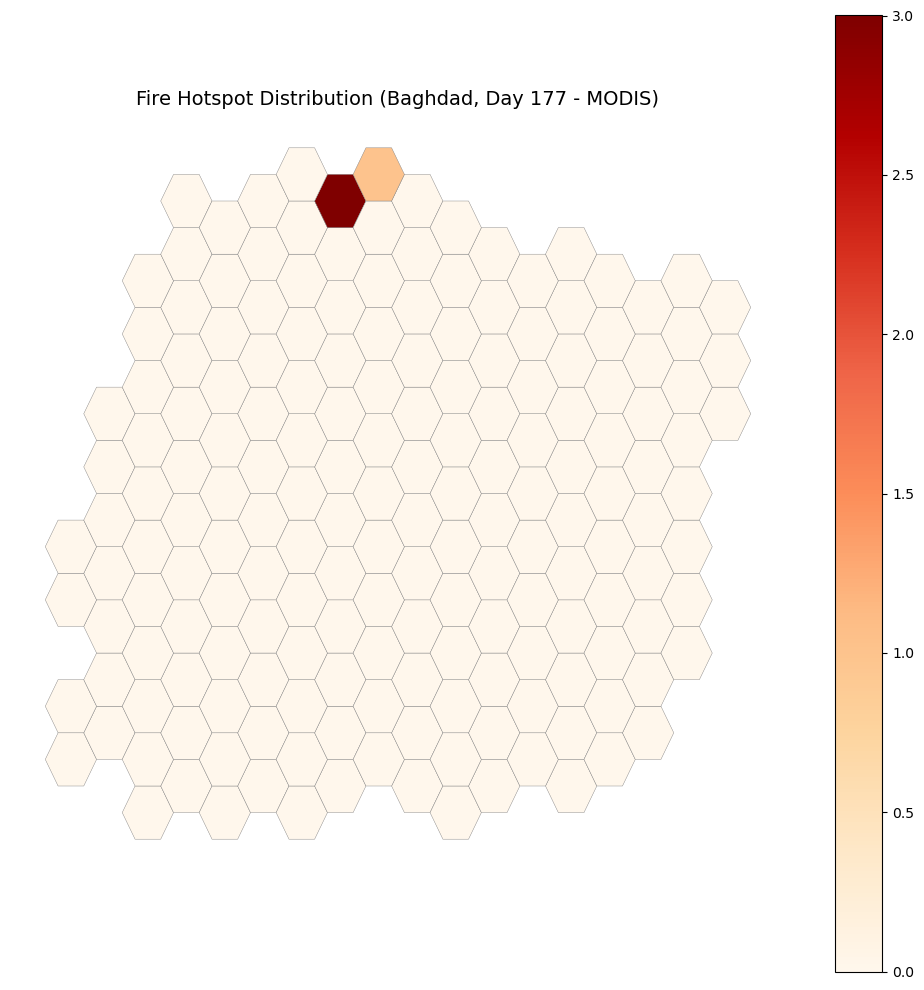

In [ ]:
# Load the aggregated result (including mesh geometry)
mesh = gpd.read_parquet("/Users/JiaSyuan/Desktop/Group 1 Design Project/Code/fire_agg_baghdad_2022177.gpq")

# Plot: color the mesh based on total fire count (fire_total)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
mesh.plot(
    column="fire_total",
    cmap="OrRd",          # Orange-red colormap, mimicking a heatmap
    linewidth=0.3,
    edgecolor="grey",
    legend=True,
    ax=ax
)

ax.set_title("Fire Hotspot Distribution (Baghdad, Day 177 - MODIS)", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

print("Total number of fire pixels in the area:", mesh["fire_total"].sum())
print("Number of hexagons with fire pixels:", (mesh["fire_total"] > 0).sum())